# <a id='toc1_'></a>[Deep Neural Network for Breast Cancer Classification](#toc0_)


**Table of contents**<a id='toc0_'></a>    
- [Deep Neural Network for Breast Cancer Classification](#toc1_)    
  - [Setup](#toc1_1_)    
  - [Load the Data](#toc1_2_)    
    - [Breast Cancer Wisconsin (Diagnostic)](#toc1_2_1_)    
  - [Data Preprocessing](#toc1_3_)    
  - [Build and Train the Neural Network Model](#toc1_4_)    
  - [Visualize the Training and Test Loss](#toc1_5_)    
  - [Changing Optimizer to SGD](#toc1_6_)    
  - [Change the number of neurons](#toc1_7_)   
  - [Changing The Number of Neurons and Changing to SGD Optimizer](#toc1_8_)   
  
  - [Try different dataset - Iris Dataset](#toc1_9_)    
  - [Authors: Christopher Banner](#toc1_10_)    



# <a id='toc1_1_'></a>[Setup](#roc0)

In [1]:
%pip install ucimlrepo==0.0.7

Note: you may need to restart the kernel to use updated packages.


In [2]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# <a id='toc1_2_'></a>[Loading the Data](#roc0)

### Breast Cancer Wisconsin (Diagnostic)


The [Breast Cancer Wisconsin (Diagnostic) dataset](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)) is a classic dataset used for classification tasks. It contains 569 samples of breast cancer cells, each with 30 features. The dataset is divided into two classes: benign and malignant. The goal is to classify the breast cancer cells into one of the two classes.

This dataset is free to use and is licensed under a Creative Commons Attribution 4.0 International (CC BY 4.0) license.

In [3]:
from ucimlrepo import fetch_ucirepo  # Import the function to fetch datasets from UCI ML Repo

# fetch dataset 
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)  # Fetch the Breast Cancer Wisconsin Diagnostic dataset by its ID

# data (as pandas dataframes) 
X = breast_cancer_wisconsin_diagnostic.data.features  # Extract the features as a pandas DataFrame
y = breast_cancer_wisconsin_diagnostic.data.targets   # Extract the targets as a pandas DataFrame

# print the first few rows of the data
display(X.head())  # Display the first five rows of the features DataFrame

# print the first few rows of the target
display(y.head())  # Display the first five rows of the targets DataFrame

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


,Diagnosis
0,M
1,M
2,M
3,M
4,M


In [4]:
display(f'X shape: {X.shape}')  # Display the shape of the features DataFrame
display(f'y shape: {y.shape}')  # Display the shape of the targets DataFrame
display(y['Diagnosis'].value_counts())  # Display the count of each unique value in the 'Diagnosis' column of the targets DataFrame

'X shape: (569, 30)'

'y shape: (569, 1)'

Diagnosis
B    357
M    212
Name: count, dtype: int64

The dataset is **imbalanced**, with more benign samples than malignant samples. So I will process the data and randomly select 200 samples from each malignant and benign.

In [5]:
# Combine features and target into a single DataFrame for easier manipulation
data = pd.concat([X, y], axis=1)  # Concatenate features and target DataFrames along columns

# Separate the two classes
data_B = data[data['Diagnosis'] == 'B']  # Select all rows where Diagnosis is 'B' (benign)
data_M = data[data['Diagnosis'] == 'M']  # Select all rows where Diagnosis is 'M' (malignant)

# Select 200 samples from each class
data_B = data_B.sample(n=200, random_state=42)  # Randomly sample 200 benign cases
data_M = data_M.sample(n=200, random_state=42)  # Randomly sample 200 malignant cases

# Combine the two classes
balanced_data = pd.concat([data_B, data_M])  # Concatenate the sampled benign and malignant data

display(balanced_data['Diagnosis'].value_counts())  # Display the count of each class in the balanced dataset

Diagnosis
B    200
M    200
Name: count, dtype: int64

# <a id='toc1_3_'></a>[Data Preprocessing](#roc0)

In [6]:
# Separate features and targets
X = balanced_data.drop('Diagnosis', axis=1)  # Remove the 'Diagnosis' column to get features
y = balanced_data['Diagnosis']  # Extract the 'Diagnosis' column as the target

# Convert the targets to binary labels
y = y.map({'B': 0, 'M': 1})  # Map 'B' to 0 and 'M' to 1 for binary classification

display(X)  # Display the features DataFrame
display(y)  # Display the binary target Series

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
395,14.060,17.18,89.75,609.1,0.08045,0.05361,0.026810,0.03251,0.1641,0.05764,...,14.92,25.34,96.42,684.5,0.10660,0.12310,0.08460,0.07911,0.2523,0.06609
110,9.777,16.99,62.50,290.2,0.10370,0.08404,0.043340,0.01778,0.1584,0.07065,...,11.05,21.47,71.68,367.0,0.14670,0.17650,0.13000,0.05334,0.2533,0.08468
481,13.900,19.24,88.73,602.9,0.07991,0.05326,0.029950,0.02070,0.1579,0.05594,...,16.41,26.42,104.40,830.5,0.10640,0.14150,0.16730,0.08150,0.2356,0.07603
493,12.460,12.83,78.83,477.3,0.07372,0.04043,0.007173,0.01149,0.1613,0.06013,...,13.19,16.36,83.24,534.0,0.09439,0.06477,0.01674,0.02680,0.2280,0.07028
136,11.710,16.67,74.72,423.6,0.10510,0.06095,0.035920,0.02600,0.1339,0.05945,...,13.33,25.48,86.16,546.7,0.12710,0.10280,0.10460,0.06968,0.1712,0.07343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,15.320,17.27,103.20,713.3,0.13350,0.22840,0.244800,0.12420,0.2398,0.07596,...,17.73,22.66,119.80,928.8,0.17650,0.45030,0.44290,0.22290,0.3258,0.11910
328,16.270,20.71,106.90,813.7,0.11690,0.13190,0.147800,0.08488,0.1948,0.06277,...,19.28,30.38,129.80,1121.0,0.15900,0.29470,0.35970,0.15830,0.3103,0.08200
199,14.450,20.22,94.49,642.7,0.09872,0.12060,0.118000,0.05980,0.1950,0.06466,...,18.33,30.12,117.90,1044.0,0.15520,0.40560,0.49670,0.18380,0.4753,0.10130
194,14.860,23.21,100.40,671.4,0.10440,0.19800,0.169700,0.08878,0.1737,0.06672,...,16.08,27.78,118.60,784.7,0.13160,0.46480,0.45890,0.17270,0.3000,0.08701


395    0
110    0
481    0
493    0
136    0
      ..
257    1
328    1
199    1
194    1
223    1
Name: Diagnosis, Length: 400, dtype: int64

Now I will split the data into training and test sets, then standardize the feature values using the `StandardScaler` from scikit-learn.

Standardizing the data involves transforming the features so that they have a mean of 0 and a standard deviation of 1. This helps in ensuring that all features contribute equally to the result and helps the model converge faster during training.

1. **Splitting the Data**: First, I split the data into training and test sets using `train_test_split`.
2. **Fitting the Scaler**: I calculate the mean and standard deviation for each feature in the training set using the `fit` method of the `StandardScaler`.
3. **Transforming the Training Data**: I apply the standardization to the training data using the `transform` method, which scales the features accordingly.
4. **Transforming the Test Data**: I apply the same transformation to the test data using the same scaler. This ensures that both training and test sets are standardized in the same way.

By standardizing the data, I am making sure that each feature contributes equally to the training process, which helps in achieving better performance and faster convergence of the neural network model.

Converting to PyTorch tensors is the last step.

In [7]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)  # Split the data into 80% train and 20% test, stratified by the target

print(f'X_train shape: {X_train.shape}')  # Display the shape of the training features
print(f'y_train shape: {y_train.shape}')  # Display the shape of the training targets
print(f'X_test shape: {X_test.shape}')    # Display the shape of the test features
print(f'y_test shape: {y_test.shape}')    # Display the shape of the test targets

X_train shape: (320, 30)
y_train shape: (320,)
X_test shape: (80, 30)
y_test shape: (80,)


In [8]:
# Standardize the data
# Initialize the StandardScaler
scaler = StandardScaler()  # Create a StandardScaler instance

# Fit the scaler on the training data and transform it
X_train = scaler.fit_transform(X_train)  # Fit to training data and transform

# Transform the test data using the same scaler
X_test = scaler.transform(X_test)  # Transform test data using the fitted scaler

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)  # Convert training features to float32 tensor
X_test = torch.tensor(X_test, dtype=torch.float32)    # Convert test features to float32 tensor
y_train = torch.tensor(y_train.values, dtype=torch.long)  # Convert training targets to long tensor
y_test = torch.tensor(y_test.values, dtype=torch.long)    # Convert test targets to long tensor

# Create DataLoader for training and test sets
train_dataset = TensorDataset(X_train, y_train)  # Create a TensorDataset for training data
test_dataset = TensorDataset(X_test, y_test)     # Create a TensorDataset for test data

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)   # DataLoader for training data
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)    # DataLoader for test data

# <a id='toc1_4_'></a>[Build and Train the Neural Network Model](#toc0_)

##### Below I will start defining the network architecuter and training the model.<br/>
##### #`nn.Module` from PyTorch will be used and the output layer will contain 2 neurons (corresponding with the two classes I have)<br/>
<img src="Images/8-8-2.jpg" alt="image" width="50%">

In [9]:
class ClassificationNet(nn.Module):
    def __init__(self, input_units=30, hidden_units=64, output_units=2):
        super(ClassificationNet, self).__init__()  # Call the parent class constructor
        self.fc1 = nn.Linear(input_units, hidden_units)  # First fully connected layer
        self.fc2 = nn.Linear(hidden_units, output_units)  # Output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Apply ReLU activation to the first layer
        x = self.fc2(x)  # Output layer (no activation, as CrossEntropyLoss expects raw logits)
        return x

# Instantiate the model
model = ClassificationNet(input_units=30, hidden_units=64, output_units=2)  # Create an instance of the network

print(model)  # Print the model architecture

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Use cross-entropy loss for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Use Adam optimizer with learning rate 0.001

ClassificationNet(
  (fc1): Linear(in_features=30, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)


In [10]:
epochs = 10  # Number of training epochs
train_losses = []  # List to store training loss for each epoch
test_losses = []   # List to store test loss for each epoch

for epoch in range(epochs):
    # Training phase
    model.train()  # Set the model to training mode
    running_loss = 0.0  # Initialize running loss for this epoch
    for X_batch, y_batch in train_loader:  # Iterate over batches in the training loader
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(X_batch)  # Forward pass
        loss = criterion(outputs, y_batch)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model parameters
        running_loss += loss.item()  # Accumulate loss

    train_loss = running_loss / len(train_loader)  # Average training loss for this epoch
    train_losses.append(train_loss)  # Store training loss
    
    # Evaluation phase on test set
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0  # Initialize test loss
    with torch.no_grad():  # Disable gradient computation for evaluation
        for X_batch, y_batch in test_loader:  # Iterate over batches in the test loader
            test_outputs = model(X_batch)  # Forward pass
            loss = criterion(test_outputs, y_batch)  # Compute loss
            test_loss += loss.item()  # Accumulate test loss

    test_loss /= len(test_loader)  # Average test loss for this epoch
    test_losses.append(test_loss)  # Store test loss
    
    print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')  # Print losses for this epoch

Epoch [1/10], Train Loss: 0.2568, Test Loss: 0.1799
Epoch [2/10], Train Loss: 0.1175, Test Loss: 0.1363
Epoch [3/10], Train Loss: 0.0885, Test Loss: 0.1240
Epoch [4/10], Train Loss: 0.0780, Test Loss: 0.1142
Epoch [5/10], Train Loss: 0.0711, Test Loss: 0.1079
Epoch [6/10], Train Loss: 0.0647, Test Loss: 0.1080
Epoch [7/10], Train Loss: 0.0607, Test Loss: 0.1010
Epoch [8/10], Train Loss: 0.0551, Test Loss: 0.0998
Epoch [9/10], Train Loss: 0.0511, Test Loss: 0.0983
Epoch [10/10], Train Loss: 0.0483, Test Loss: 0.0947


# <a id='toc1_5_'></a>[Visualize the Training and Test Loss](#toc0_)

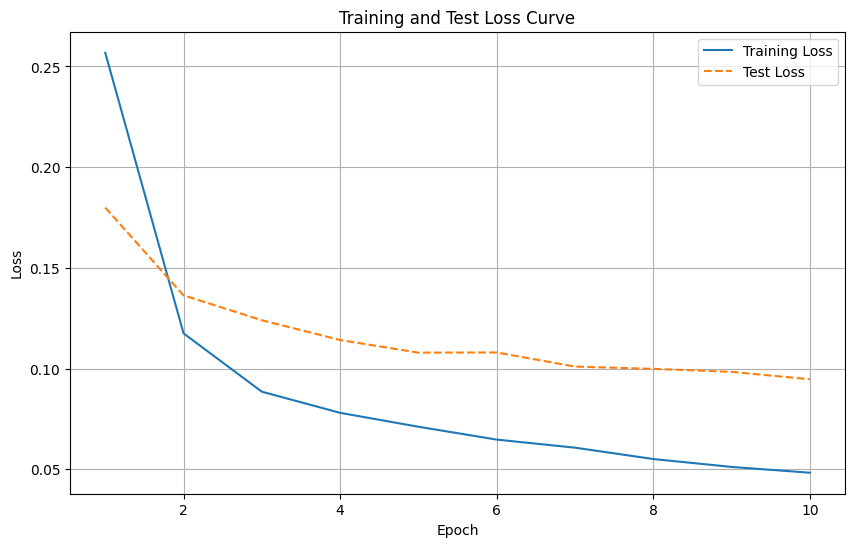

In [11]:
# Plot the loss curves
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')  # Plot training loss
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss', linestyle='--')  # Plot test loss with dashed line
plt.xlabel('Epoch')  # Label for x-axis
plt.ylabel('Loss')  # Label for y-axis
plt.title('Training and Test Loss Curve')  # Title of the plot
plt.legend()  # Show legend
plt.grid(True)  # Show grid
plt.show()  # Display the plot

# <a id='toc1_6_'></a>[Changing Optimizer to SGD](#toc0_)


In [12]:
import torch.optim as optim  # Import the optim module from PyTorch

model_new_optimizer = ClassificationNet(input_units=30, hidden_units=64, output_units=2)  # Instantiate the model

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Use cross-entropy loss for classification
optimizer = optim.SGD(model_new_optimizer.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)  # Use SGD optimizer with momentum and weight decay

Epoch [1/10], Train Loss: 0.3638, Test Loss: 0.2850
Epoch [2/10], Train Loss: 0.1887, Test Loss: 0.2134
Epoch [3/10], Train Loss: 0.1419, Test Loss: 0.1792
Epoch [4/10], Train Loss: 0.1199, Test Loss: 0.1585
Epoch [5/10], Train Loss: 0.1073, Test Loss: 0.1485
Epoch [6/10], Train Loss: 0.0978, Test Loss: 0.1396
Epoch [7/10], Train Loss: 0.0916, Test Loss: 0.1328
Epoch [8/10], Train Loss: 0.0869, Test Loss: 0.1272
Epoch [9/10], Train Loss: 0.0827, Test Loss: 0.1235
Epoch [10/10], Train Loss: 0.0789, Test Loss: 0.1203


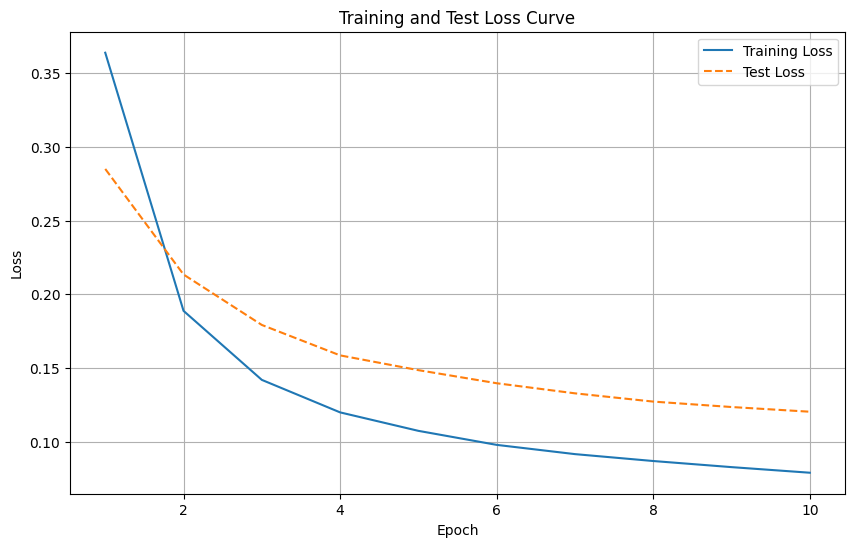

In [13]:
epochs = 10  # Number of training epochs
train_losses = []  # List to store training loss for each epoch
test_losses = []   # List to store test loss for each epoch

for epoch in range(epochs):
    # Training phase
    model_new_optimizer.train()  # Set the model to training mode
    running_loss = 0.0  # Initialize running loss for this epoch
    for X_batch, y_batch in train_loader:  # Iterate over batches in the training loader
        optimizer.zero_grad()  # Zero the gradients
        outputs = model_new_optimizer(X_batch)  # Forward pass
        loss = criterion(outputs, y_batch)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model parameters
        running_loss += loss.item()  # Accumulate loss

    train_loss = running_loss / len(train_loader)  # Average training loss for this epoch
    train_losses.append(train_loss)  # Store training loss
    
    # Evaluation phase on test set
    model_new_optimizer.eval()  # Set the model to evaluation mode
    test_loss = 0.0  # Initialize test loss
    with torch.no_grad():  # Disable gradient computation for evaluation
        for X_batch, y_batch in test_loader:  # Iterate over batches in the test loader
            test_outputs = model_new_optimizer(X_batch)  # Forward pass
            loss = criterion(test_outputs, y_batch)  # Compute loss
            test_loss += loss.item()  # Accumulate test loss

    test_loss /= len(test_loader)  # Average test loss for this epoch
    test_losses.append(test_loss)  # Store test loss
    
    print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')  # Print losses for this epoch

import matplotlib.pyplot as plt  # Import matplotlib for plotting

# Plot the loss curves
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')  # Plot training loss
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss', linestyle='--')  # Plot test loss with dashed line
plt.xlabel('Epoch')  # Label for x-axis
plt.ylabel('Loss')  # Label for y-axis
plt.title('Training and Test Loss Curve')  # Title of the plot
plt.legend()  # Show legend
plt.grid(True)  # Show grid
plt.show()  # Display the plot

# <a id='toc1_7_'></a>[Changing The Number of Neurons](#toc0_)


Epoch [1/10], Train Loss: 0.3502, Test Loss: 0.2310
Epoch [2/10], Train Loss: 0.1432, Test Loss: 0.1624
Epoch [3/10], Train Loss: 0.1040, Test Loss: 0.1367
Epoch [4/10], Train Loss: 0.0863, Test Loss: 0.1222
Epoch [5/10], Train Loss: 0.0780, Test Loss: 0.1133
Epoch [6/10], Train Loss: 0.0717, Test Loss: 0.1091
Epoch [7/10], Train Loss: 0.0658, Test Loss: 0.1011
Epoch [8/10], Train Loss: 0.0612, Test Loss: 0.1000
Epoch [9/10], Train Loss: 0.0578, Test Loss: 0.0919
Epoch [10/10], Train Loss: 0.0536, Test Loss: 0.0925


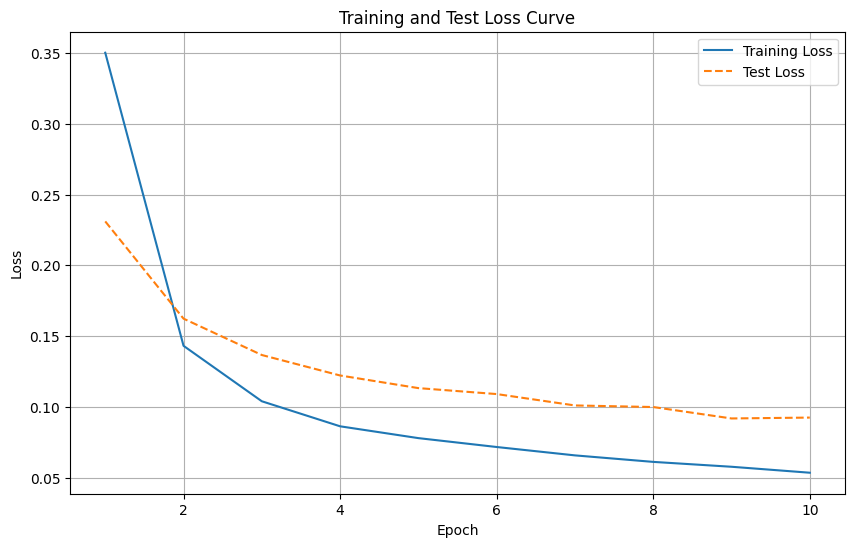

In [14]:
# Change the number of hidden units, e.g. 32.
model_new = ClassificationNet(input_units=30, hidden_units=32, output_units=2)  # Create a new model with 32 hidden units

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Use cross-entropy loss for classification tasks
optimizer = optim.Adam(model_new.parameters(), lr=0.001)  # Use Adam optimizer with a learning rate of 0.001

epochs = 10  # Set the number of epochs for training
train_losses = []  # List to store training loss for each epoch
test_losses = []   # List to store test loss for each epoch

for epoch in range(epochs):  # Loop over the number of epochs
    # Training phase
    model_new.train()  # Set the model to training mode (enables dropout, batchnorm, etc.)
    running_loss = 0.0  # Initialize running loss for this epoch
    for X_batch, y_batch in train_loader:  # Iterate over batches in the training data
        optimizer.zero_grad()  # Reset gradients to zero before each batch
        outputs = model_new(X_batch)  # Forward pass: compute model predictions for the batch
        loss = criterion(outputs, y_batch)  # Compute the loss between predictions and true labels
        loss.backward()  # Backpropagate the loss to compute gradients
        optimizer.step()  # Update model parameters using the optimizer
        running_loss += loss.item()  # Accumulate the loss for this batch

    train_loss = running_loss / len(train_loader)  # Calculate average training loss for the epoch
    train_losses.append(train_loss)  # Store the training loss
    
    # Evaluation phase on test set
    model_new.eval()  # Set the model to evaluation mode (disables dropout, batchnorm, etc.)
    test_loss = 0.0  # Initialize test loss for this epoch
    with torch.no_grad():  # Disable gradient computation for evaluation
        for X_batch, y_batch in test_loader:  # Iterate over batches in the test data
            test_outputs = model_new(X_batch)  # Forward pass: compute predictions for the test batch
            loss = criterion(test_outputs, y_batch)  # Compute the loss for the test batch
            test_loss += loss.item()  # Accumulate the test loss

    test_loss /= len(test_loader)  # Calculate average test loss for the epoch
    test_losses.append(test_loss)  # Store the test loss
    
    print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')  # Print losses for this epoch

import matplotlib.pyplot as plt  # Import matplotlib for plotting

# Plot the loss curves
plt.figure(figsize=(10, 6))  # Create a new figure with specified size
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')  # Plot training loss curve
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss', linestyle='--')  # Plot test loss curve with dashed line
plt.xlabel('Epoch')  # Set the x-axis label
plt.ylabel('Loss')  # Set the y-axis label
plt.title('Training and Test Loss Curve')  # Set the plot title
plt.legend()  # Display the legend
plt.grid(True)  # Show grid lines for better readability
plt.show()  # Display the plot

# <a id='toc1_8_'></a>[Changing The Number of Neurons and Changing to SGD Optimizer](#toc0_)


Epoch [1/10], Train Loss: 0.1861, Test Loss: 0.1360
Epoch [2/10], Train Loss: 0.0925, Test Loss: 0.1104
Epoch [3/10], Train Loss: 0.0821, Test Loss: 0.0935
Epoch [4/10], Train Loss: 0.0645, Test Loss: 0.0959
Epoch [5/10], Train Loss: 0.0640, Test Loss: 0.1100
Epoch [6/10], Train Loss: 0.0608, Test Loss: 0.2711
Epoch [7/10], Train Loss: 0.0722, Test Loss: 0.0834
Epoch [8/10], Train Loss: 0.0602, Test Loss: 0.1753
Epoch [9/10], Train Loss: 0.0504, Test Loss: 0.0863
Epoch [10/10], Train Loss: 0.0387, Test Loss: 0.0982


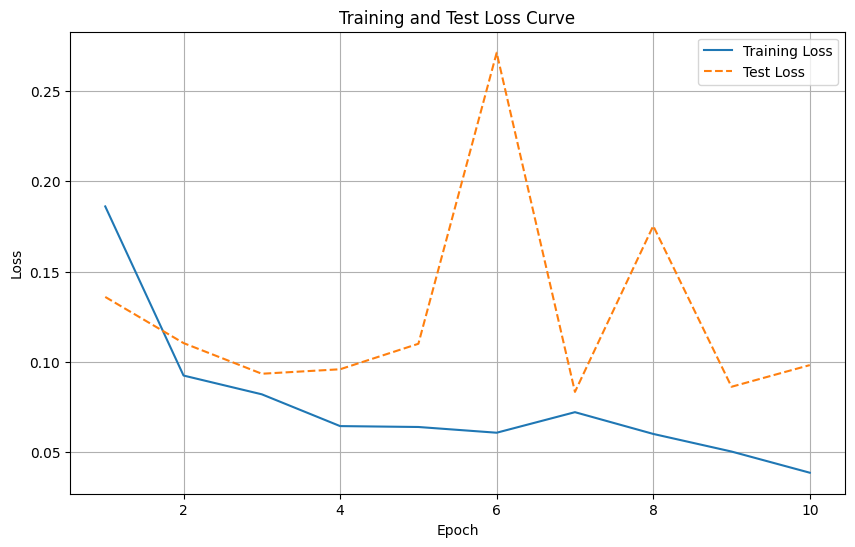

In [16]:
# Change the number of hidden units, e.g. 32.
model_new_SGD = ClassificationNet(input_units=30, hidden_units=32, output_units=2)  # Create a new model with 32 hidden units
    
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Use cross-entropy loss for classification tasks
optimizer = optim.SGD(model_new_SGD.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)  # Use SGD optimizer with momentum

epochs = 10  # Set the number of epochs for training
train_losses = []  # List to store training loss for each epoch
test_losses = []   # List to store test loss for each epoch

for epoch in range(epochs):  # Loop over the number of epochs
    # Training phase
    model_new_SGD.train()  # Set the model to training mode (enables dropout, batchnorm, etc.)
    running_loss = 0.0  # Initialize running loss for this epoch
    for X_batch, y_batch in train_loader:  # Iterate over batches in the training data
        optimizer.zero_grad()  # Reset gradients to zero before each batch
        outputs = model_new_SGD(X_batch)  # Forward pass: compute model predictions for the batch
        loss = criterion(outputs, y_batch)  # Compute the loss between predictions and true labels
        loss.backward()  # Backpropagate the loss to compute gradients
        optimizer.step()  # Update model parameters using the optimizer
        running_loss += loss.item()  # Accumulate the loss for this batch

    train_loss = running_loss / len(train_loader)  # Calculate average training loss for the epoch
    train_losses.append(train_loss)  # Store the training loss
    
    # Evaluation phase on test set
    model_new_SGD.eval()  # Set the model to evaluation mode (disables dropout, batchnorm, etc.)
    test_loss = 0.0  # Initialize test loss for this epoch
    with torch.no_grad():  # Disable gradient computation for evaluation
        for X_batch, y_batch in test_loader:  # Iterate over batches in the test data
            test_outputs = model_new_SGD(X_batch)  # Forward pass: compute predictions for the test batch
            loss = criterion(test_outputs, y_batch)  # Compute the loss for the test batch
            test_loss += loss.item()  # Accumulate the test loss

    test_loss /= len(test_loader)  # Calculate average test loss for the epoch
    test_losses.append(test_loss)  # Store the test loss
    
    print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')  # Print losses for this epoch

import matplotlib.pyplot as plt  # Import matplotlib for plotting

# Plot the loss curves
plt.figure(figsize=(10, 6))  # Create a new figure with specified size
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')  # Plot training loss curve
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss', linestyle='--')  # Plot test loss curve with dashed line
plt.xlabel('Epoch')  # Set the x-axis label
plt.ylabel('Loss')  # Set the y-axis label
plt.title('Training and Test Loss Curve')  # Set the plot title
plt.legend()  # Display the legend
plt.grid(True)  # Show grid lines for better readability
plt.show()  # Display the plot

# <a id='toc1_9_'></a>[Changing The Dataset](#toc0_)


In [17]:
from sklearn.datasets import load_iris  # Import the function to load the Iris dataset

# Load the Iris dataset
iris = load_iris()  # Load the dataset into a dictionary-like object

# Extract the features and target variable
X_iris = iris.data  # Features: shape (150, 4), each row is a sample, each column is a feature
y_iris = iris.target  # Target: shape (150,), contains class labels (0, 1, 2)

#### Preprocessing The Data

In [21]:
iris = load_iris()  # Load the Iris dataset again to ensure it's fresh

# Extract the features and target variable
X_iris = iris.data  # Features: shape (150, 4), each row is a sample, each column is a feature
y_iris = iris.target  # Target: shape (150,), contains class labels (0, 1, 2)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_iris, y_iris, test_size=0.2, random_state=42, stratify=y_iris)  # Split the dataset into training and test sets

# Standardize the data
scaler_iris = StandardScaler()  # Create a StandardScaler instance
X_train = scaler_iris.fit_transform(X_train)  # Fit the scaler on the training data and transform it
X_test = scaler_iris.transform(X_test)  # Transform the test data using the fitted scaler

# Convert to PyTorch tensors
X_train_iris = torch.tensor(X_train, dtype=torch.float32)  # Convert training features to float32 tensor
X_test_iris = torch.tensor(X_test, dtype=torch.float32)    # Convert test features to float32 tensor
y_train_iris = torch.tensor(y_train, dtype=torch.long)  # Convert training targets to long tensor
y_test_iris = torch.tensor(y_test, dtype=torch.long)    # Convert test targets to long tensor

#### Creating the DataLoader for training and test sets

In [22]:
# Create DataLoader for training and test sets
train_dataset_iris = TensorDataset(X_train_iris, y_train_iris)  # Create a TensorDataset for training data
test_dataset_iris = TensorDataset(X_test_iris, y_test_iris)     # Create a TensorDataset for test data

# Create DataLoader for training and test sets
train_loader_iris = DataLoader(train_dataset_iris, batch_size=32, shuffle=True)   # DataLoader for training data
test_loader_iris = DataLoader(test_dataset_iris, batch_size=32, shuffle=False)    # DataLoader for test data



#### Creating the `nn.Module` class

In [38]:
class IrisNet(nn.Module):
    def __init__(self, hidden_units=32):
        super(IrisNet, self).__init__()  # Call the parent class constructor
        self.fc1 = nn.Linear(4, hidden_units)  # First layer: 4 input features (Iris dataset), hidden_units outputs
        self.fc2 = nn.Linear(hidden_units, 3)  # Output layer: hidden_units inputs, 3 outputs (3 classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Apply ReLU activation after first layer
        x = self.fc2(x)              # Output logits for 3 classes
        return x

model = IrisNet(hidden_units=8)  # Instantiate the model with 8 hidden units
print(model)  # Print the model architecture

IrisNet(
  (fc1): Linear(in_features=4, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=3, bias=True)
)


#### Defining the Loss Function and Optimizer

In [39]:
# Defining the Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()  # Use cross-entropy loss for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.01)  # Adam optimizer with learning rate 0.01

epochs = 100  # Number of epochs to train
train_losses = []  # List to store average training loss per epoch
test_losses = []   # List to store average test loss per epoch

# Setting up the training loop
for epoch in range(epochs):  # Loop over each epoch
    model.train()  # Set model to training mode
    running_loss = 0.0  # Accumulate training loss for this epoch
    for X_batch, y_batch in train_loader_iris:  # Iterate over training batches
        optimizer.zero_grad()  # Clear gradients before each batch
        outputs = model(X_batch)  # Forward pass: compute predictions
        loss = criterion(outputs, y_batch)  # Compute loss for this batch
        loss.backward()  # Backpropagate to compute gradients
        optimizer.step()  # Update model parameters
        running_loss += loss.item()  # Add batch loss to running total
        
    avg_train_loss = running_loss / len(train_loader_iris)  # Average training loss for the epoch
    train_losses.append(avg_train_loss)  # Store training loss
    
    model.eval()  # Set model to evaluation mode
    test_loss = 0.0  # Accumulate test loss for this epoch
    with torch.no_grad():  # Disable gradient computation for evaluation
        for X_batch, y_batch in test_loader_iris:  # Iterate over test batches
            test_outputs = model(X_batch)  # Forward pass on test data
            loss = criterion(test_outputs, y_batch)  # Compute test loss
            test_loss += loss.item()  # Add batch loss to running total
        
    avg_test_loss = test_loss / len(test_loader_iris)  # Average test loss for the epoch
    test_losses.append(avg_test_loss)  # Store test loss
    
    print(f'Epoch [{epoch + 1} / {epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')  # Print losses for this epoch

Epoch [1 / 100], Train Loss: 1.1077, Test Loss: 1.0164
Epoch [2 / 100], Train Loss: 0.9819, Test Loss: 0.9081
Epoch [3 / 100], Train Loss: 0.8715, Test Loss: 0.8119
Epoch [4 / 100], Train Loss: 0.7825, Test Loss: 0.7309
Epoch [5 / 100], Train Loss: 0.7103, Test Loss: 0.6689
Epoch [6 / 100], Train Loss: 0.6436, Test Loss: 0.6233
Epoch [7 / 100], Train Loss: 0.6108, Test Loss: 0.5893
Epoch [8 / 100], Train Loss: 0.5821, Test Loss: 0.5615
Epoch [9 / 100], Train Loss: 0.5449, Test Loss: 0.5389
Epoch [10 / 100], Train Loss: 0.5269, Test Loss: 0.5195
Epoch [11 / 100], Train Loss: 0.5020, Test Loss: 0.5020
Epoch [12 / 100], Train Loss: 0.4852, Test Loss: 0.4867
Epoch [13 / 100], Train Loss: 0.4783, Test Loss: 0.4727
Epoch [14 / 100], Train Loss: 0.4548, Test Loss: 0.4603
Epoch [15 / 100], Train Loss: 0.4398, Test Loss: 0.4479
Epoch [16 / 100], Train Loss: 0.4293, Test Loss: 0.4362
Epoch [17 / 100], Train Loss: 0.4121, Test Loss: 0.4244
Epoch [18 / 100], Train Loss: 0.4008, Test Loss: 0.4125
E

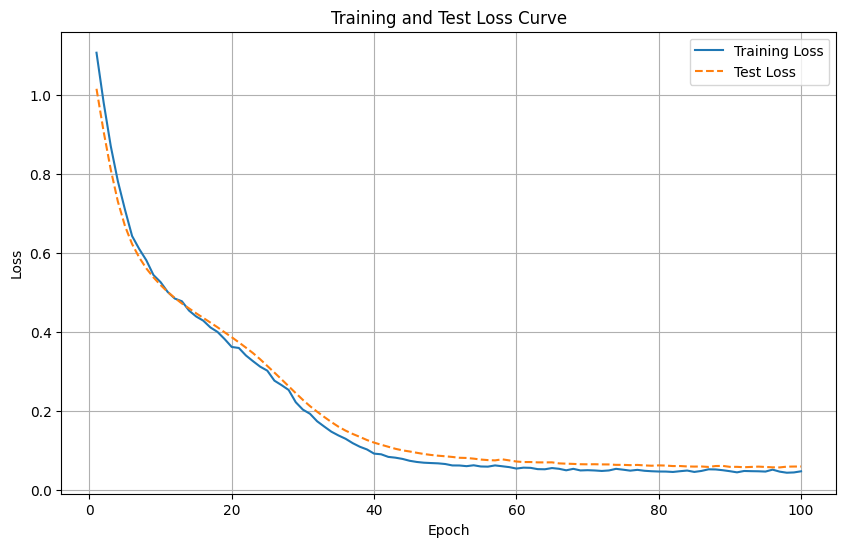

In [40]:
# Plotting the Loss curves
plt.figure(figsize=(10,6))  # Create a new figure with a size of 10x6 inches
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss")  # Plot training loss for each epoch
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss', linestyle='--')  # Plot test loss for each epoch with dashed line
plt.xlabel('Epoch')  # Label the x-axis as 'Epoch'
plt.ylabel('Loss')  # Label the y-axis as 'Loss'
plt.title('Training and Test Loss Curve')  # Set the plot title
plt.legend()  # Display the legend to differentiate between training and test loss
plt.grid(True)  # Show grid lines for better readability
plt.show()  # Render and display the plot

In [41]:
# Calculate accuracy on test set
model.eval()  # Set the model to evaluation mode (disables dropout, etc.)
correct = 0  # Initialize counter for correct predictions
total = 0    # Initialize counter for total samples
with torch.no_grad():  # Disable gradient computation for evaluation
    for X_batch, y_batch in test_loader_iris:  # Iterate over batches in the test DataLoader
        outputs = model(X_batch)  # Get model predictions (logits) for the batch
        _, predicted = torch.max(outputs, 1)  # Get the predicted class indices
        total += y_batch.size(0)  # Increment total by the batch size
        correct += (predicted == y_batch).sum().item()  # Increment correct by number of correct predictions in batch
print(f'Test Accuracy: {100 * correct / total:.2f}%')  # Print the test accuracy as a percentage

Test Accuracy: 100.00%
